# LSTM Model

In [1]:
#imported python packages
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import time
import joblib

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

2022-12-13 11:35:47.128082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 11:35:47.344707: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-13 11:35:47.393377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 11:35:47.393392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
# imported training dataset
train_df = pd.read_csv('train.csv')
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150047 entries, 0 to 3150046
Data columns (total 28 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int64  
 1   shop_id                         int64  
 2   item_id                         int64  
 3   item_price                      float64
 4   item_cnt_day                    float64
 5   revenue                         float64
 6   item_cnt_month                  float64
 7   city_code                       int64  
 8   item_category_id                int64  
 9   type_code                       int64  
 10  subtype_code                    int64  
 11  date_avg_item_cnt               float64
 12  date_item_avg_item_cnt          float64
 13  date_shop_avg_item_cnt          float64
 14  date_cat_avg_item_cnt           float64
 15  date_shop_cat_avg_item_cnt      float64
 16  date_shop_type_avg_item_cnt     float64
 17  date_shop_subtype_avg_item_

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_cnt_month,city_code,item_category_id,type_code,...,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,delta_revenue,month
0,0,59,22154,999.00,1.0,999.00,1.0,31,37,11,...,3.836,1.0,3.697,2.463,410.5,999.0,1633431.0,1292188.0,0.2642,0
1,0,25,2552,899.00,1.0,899.00,0.0,14,58,13,...,5.152,0.0,2.076,1.253,938.0,899.0,5376478.0,6185159.0,-0.1307,0
2,0,25,2552,899.00,-1.0,-899.00,0.0,14,58,13,...,5.152,0.0,2.076,1.253,938.0,899.0,5376478.0,6185159.0,-0.1307,0
3,0,25,2554,1709.05,1.0,1709.05,1.0,14,58,13,...,5.152,1.0,2.076,1.253,1709.0,1709.0,5376478.0,6185159.0,-0.1307,0
4,0,25,2555,1099.00,1.0,1099.00,1.0,14,56,13,...,5.152,1.0,2.076,1.226,1123.0,1099.0,5376478.0,6185159.0,-0.1307,0


In [4]:
# dropped item_id as decided in vizualization notebook
train_df.drop(['item_id'],axis=1,inplace=True)

In [5]:
# training, validation, and test dataset is created.
X_train_df = train_df[train_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train_df = train_df[train_df.date_block_num < 33]['item_cnt_month']
X_valid = train_df[train_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train_df[train_df.date_block_num == 33]['item_cnt_month']
X_test = train_df[train_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
# reshaping training, validation and test data for LSTM model
X_train=X_train_df.values.reshape((X_train_df.shape[0],X_train_df.shape[1],1))
X_valid=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

Y_train=Y_train_df.values.reshape((Y_train_df.shape[0],1))
Y_valid=Y_valid.values.reshape((Y_valid.shape[0],1))

X_test=X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))

### Attempt to create a lstm model after understanding the data

In [7]:
# instantiate and add layers to the lstm model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
# activation is linear if not mentioned
model_lstm.add(Dense(1))
# compile the model
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

2022-12-12 18:34:30.451598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 18:34:30.453944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 18:34:30.453975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-12 18:34:30.454000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-12 18:34:30.454026: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 26, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 26, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainabl

In [8]:
# train the model
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid), batch_size=2048,verbose=1,
              epochs=10)

Epoch 1/10
1408/1408 [==============================] - 196s 138ms/step - loss: 8.1728 - mse: 8.1728 - val_loss: 2.4289 - val_mse: 2.4289
Epoch 2/10
1408/1408 [==============================] - 250s 177ms/step - loss: 3.6018 - mse: 3.6018 - val_loss: 2.0237 - val_mse: 2.0237
Epoch 3/10
1408/1408 [==============================] - 247s 175ms/step - loss: 3.2452 - mse: 3.2452 - val_loss: 1.9895 - val_mse: 1.9895
Epoch 4/10
1408/1408 [==============================] - 248s 176ms/step - loss: 3.1110 - mse: 3.1110 - val_loss: 1.7772 - val_mse: 1.7772
Epoch 5/10
1408/1408 [==============================] - 242s 172ms/step - loss: 2.9890 - mse: 2.9890 - val_loss: 1.6393 - val_mse: 1.6393
Epoch 6/10
1408/1408 [==============================] - 241s 171ms/step - loss: 2.8933 - mse: 2.8933 - val_loss: 1.6727 - val_mse: 1.6727
Epoch 7/10
1408/1408 [==============================] - 240s 170ms/step - loss: 2.8190 - mse: 2.8190 - val_loss: 1.5300 - val_mse: 1.5300
Epoch 8/10
1408/1408 [============

In [9]:
# the optimal epoch for the model
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
# it is the lowest mean squared error for validation and its corresponding for train dataset
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

Optimal Epoch: {} 8
Train Score: 2.721200704574585, Validation Score: 1.4505866765975952


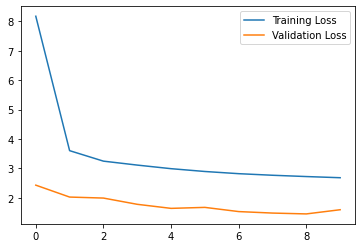

In [10]:
# plot for training and validation loss
plt.plot(range(len(hist.history["loss"])),hist.history["loss"],label="Training Loss")
plt.plot(range(len(hist.history["val_loss"])),hist.history["val_loss"],label="Validation Loss")
plt.legend()

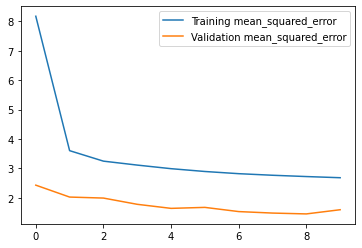

In [11]:
# plot for mean squared error and mean squared error for validation
plt.plot(range(len(hist.history["mse"])),hist.history["mse"],label="Training mean_squared_error")
plt.plot(range(len(hist.history["val_mse"])),hist.history["val_mse"],label="Validation mean_squared_error")
plt.legend()

#### validation loss/mse is consistently lower than the training loss/mse, the gap between them remains more or less the same size. It means the model is more accurate on the training model than validation or test.

In [12]:
# evaluate the validation data to get metrics of the model for validation data
scores = model_lstm.evaluate(X_valid,Y_valid)
print(scores)

1673/1673 [==============================] - 10s 6ms/step - loss: 1.5930 - mse: 1.5930
[1.5930320024490356, 1.5930320024490356]


In [13]:
# get the predictions for the validation data
Y_pred = model_lstm.predict(X_valid)

1673/1673 [==============================] - 11s 6ms/step


In [14]:
# RMSE metric for the predicted and actual data
print('LSTMModel RMSE =', mean_squared_error(Y_valid, Y_pred,squared=False))

LSTMModel RMSE = 1.2621537665315472


In [20]:
# Model saved
filename = "lstm_model.joblib"
joblib.dump(model_lstm, filename)

INFO:tensorflow:Assets written to: ram://de2a9785-5f1a-40b2-b10f-10bb7a467af7/assets


INFO:tensorflow:Assets written to: ram://de2a9785-5f1a-40b2-b10f-10bb7a467af7/assets


['lstm_model.joblib']